In [1]:
import jax
from jax import random, Array
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from typing import *

from gp import k, mk_cov, cholesky_inv, PlotContext

key = random.PRNGKey(42)  # Create a random key

# Sparse GPs and Subset of Regressors (SoR)

The time complexity of GP regression with $N$ points is $O(N^3)$ which is the complexity of solving a system of $N$ linear equations. Consequently, GP regression is prohibitive for large $N$. One way to alleviate the scaling challenges of GP is to use a **sparse GP**. We will introduce a basic sparse GP called a **Subset of Regressors** (**SoR**) [1] and **Fully Indpendent Training Conditional** (FITC) [1].

## Subset of Regressors (SoR)

The **Subset of Regressors** (SoR) approach uses a set of **inducing points** $\{ z_m | z_m \in \mathbb{R}^D \}_{1 \leq m \leq M}$ for $M \ll N$ to alleviate the complexity of inference. The main idea of inducing points is to choose a subset of the dataset to approximate the entire dataset. To illustrate this, we create a synthestic dataset of $10$ datapoints along with $4$ inducing points now.

In [2]:
def create_toy_sparse_dataset(f: Callable, key) -> tuple[Array, Array, Array, Array]:
    # Data points
    N = 10
    xs = jnp.linspace(-3, 3, N).reshape(-1, 1)

    # Inducing points
    M = 4
    zs = jnp.linspace(-3, 3, M)

    # Function to approximate
    f = lambda x: jnp.sin(x)

    # Noise
    Sigma = jnp.diag(1e-2 * jnp.ones(N))
    es = random.multivariate_normal(key, mean=jnp.zeros(N), cov=Sigma, shape=(1,)).transpose()

    # Observations
    ys = jax.vmap(f)(xs) + es  # outputs
    return xs, zs, ys, Sigma

f = lambda x: jnp.sin(x)
xs, zs, ys, Sigma = create_toy_sparse_dataset(f, key)
N, M = len(xs), len(zs)

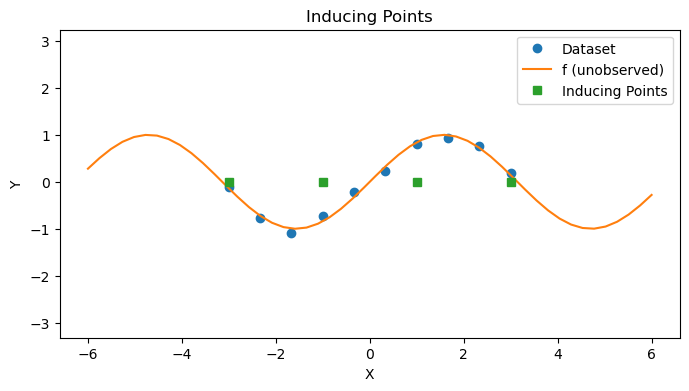

In [3]:
with PlotContext(title="Inducing Points", xlabel="X", ylabel="Y") as ax:
    # Plot dataset
    plt.plot(xs, ys, marker="o", linestyle="None", label="Dataset")
    plt.plot(jnp.linspace(-6, 6), f(jnp.linspace(-6, 6)), label="f (unobserved)")

    # Plot inducing points
    plt.plot(zs, jnp.zeros_like(zs), marker="s", linestyle="None", label="Inducing Points")

## Subset of Regressors (SoR) Model

The Subset of Regressors (SoR) model relates the inducing points with the actual dataset with the following joint distribution
\begin{align*}
u & \sim \mathcal{N}(0, K_{uu}) \\
y | u & \sim \mathcal{N}(K_{xz}K_{zz}^{-1}u, 0) \,.
\end{align*}
- The random variable $u$ represents the target value at the inducing points.
- The random variable $y | u$ represents the value of the outputs in the dataset. It is also normally distributed and is centered at $K_{xz}K_{zz}^{-1}u$ so that it is interpolated from $u$.
- Note that the covariance of the normal distribution is degenerate.

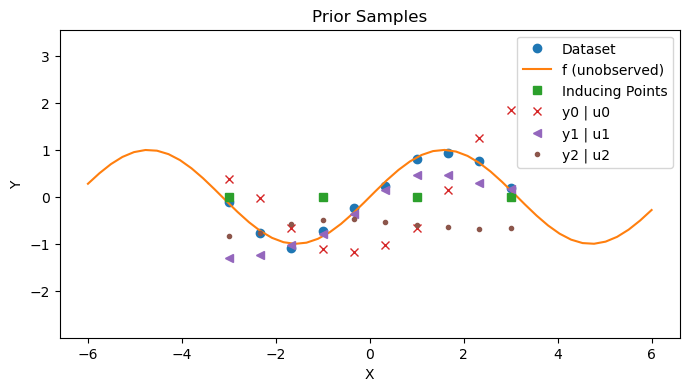

In [4]:
# Construct covariance matrices
K_zz = mk_cov(k, zs, zs)
K_zx = mk_cov(k, zs, xs)

# Sample u
us = random.multivariate_normal(key, mean=jnp.zeros(M), cov=K_zz, shape=(3,)).transpose()

# Sample y | u
ys_given_us = K_zx.transpose() @ cholesky_inv(K_zz) @ us

# Plot
with PlotContext(title="Prior Samples", xlabel="X", ylabel="Y") as ax:
    # Plot dataset and inducing points
    plt.plot(xs, ys, marker="o", linestyle="None", label="Dataset")
    plt.plot(jnp.linspace(-6, 6), f(jnp.linspace(-6, 6)), label="f (unobserved)")
    plt.plot(zs, jnp.zeros_like(zs), marker="s", linestyle="None", label="Inducing Points")

    # Plot y | u
    markers = ["x", "<", "."]
    for i, marker in enumerate(markers):
        plt.plot(xs, ys_given_us[:, i], linestyle="None", marker=marker, label=f"y{i} | u{i}")

### SoR Kernel Approximation

The inducing points enable us to create a low rank approximation of the original covariance matrix as in

$$
Q_{xx} = K_{xz}K_{zz}^{-1}K_{zx} \,.
$$

That is, $Q_{xx} \approx K_{xx}$ and is a "blurry" version of it.

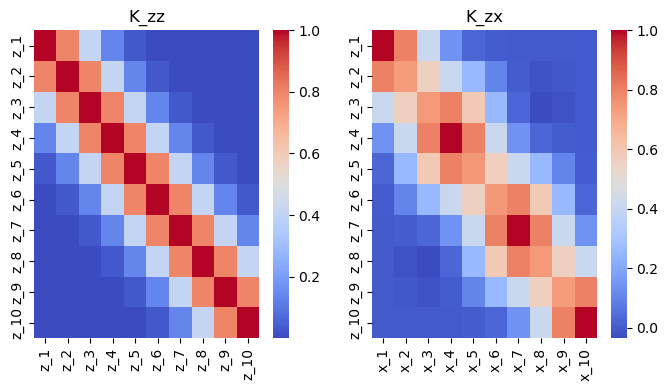

In [5]:
# Covariance matrix
K_xx = mk_cov(k, xs, xs)
Q_xx = K_zx.transpose() @ cholesky_inv(K_zz) @ K_zx

# Plot
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.heatmap(
    K_xx, annot=False, cmap='coolwarm', fmt='.2f',
    xticklabels=[f"z_{i+1}" for i in range(len(xs))],
    yticklabels=[f"z_{i+1}" for i in range(len(xs))]
)
plt.title("K_zz");
plt.subplot(1, 2, 2)
sns.heatmap(
    Q_xx, annot=False, cmap='coolwarm', fmt='.2f',
    xticklabels=[f"x_{i+1}" for i in range(len(xs))],
    yticklabels=[f"z_{i+1}" for i in range(len(xs))]
)
plt.title("K_zx");

### Notation

As notation, we will also write $K_{zx} = K_{uf}$. That is, we will conflate the domain of the kernel with the random variable.

In [6]:
K_uu = K_zz
K_uf = K_zx

## Fitting a Subset of Regressors (SoR) GP

To perform GP regression with the SoR approach, we simply replace the covariance $K_{xx}$ with its approximation $Q_{xx}$. The posterior predictive distribution is
\begin{align*}
q_{SoR}(f_* | y) & = \mathcal{N}(Q_{*f}(Q_{ff} + \Sigma)^{-1}y, Q_{* *} - Q_{*f}(Q_{ff} + \Sigma)^{-1}Q_{f*}) \tag{standard prediction with kernel Q} \\
& = \mathcal{N}(K_{*u}AK_{uf}\Sigma^{-1}y, K_{*u}AK_{u*}) \tag{see Appendix: SoR Simplification}
\end{align*}
where $A = (K_{uu} + K_{uf}\Sigma^{-1}K_{fu})^{-1}$ which is again a GP. The second form of $q_{SoR}$ is more efficient to implement. In particular, the computational complexity is $O(MN^2)$ since:
1. solving $A^{-1}$ is $O(M^3)$,
2. multiplying $K_{fu}K_{uu}^{-1}K_{uf}$ is $O(NM^2)$,
3. and $M \ll N$.

In [7]:
def calc_A(Sigma: Array, K_uu: Array, K_uf: Array) -> Array:
    return cholesky_inv(K_uu + K_uf @ cholesky_inv(Sigma) @ K_uf.transpose())

def fit_sor(k: Callable, xs: Array, ys: Array, zs: Array) -> Tuple[Array, Array, Array, Array]:
    K_uu = mk_cov(k, zs, zs)
    K_uf = mk_cov(k, zs, xs)
    Sigma_inv = cholesky_inv(Sigma)
    A = calc_A(Sigma, K_uu, K_uf)
    alpha = A @ K_uf @ Sigma_inv @ ys
    return alpha, A, K_uu, K_uf

In [8]:
alpha, A, _, _ = fit_sor(k, xs, ys, zs)
alpha

Array([[-0.20053719],
       [-0.9915333 ],
       [ 0.9843865 ],
       [ 0.2127169 ]], dtype=float32)

In [9]:
def sor_post_pred_mean(k: Callable, zs: Array, alpha: Array, x_star: Array) -> Array:
    """SoR posterior predictive mean.
    """
    K_star_u = mk_cov(k, x_star, zs).reshape(-1)
    return K_star_u @ alpha

def sor_post_pred_cov(k: Callable, Sigma: Array, zs: Array, K_uu: Array, K_uf: Array, A: Array, x_star: Array) -> Array:
    """SoR posterior predictive covariance.
    """
    K_star_u = mk_cov(k, x_star, zs)
    Sigma_inv = cholesky_inv(Sigma)
    return K_star_u @ A @ K_star_u.transpose()

### Visualizing  the posterior predictive

We visualize the covariance of the posterior predictive by sampling a few times from the posterior predictive. Observe that the SoR approach results in a degenerate posterior covariance.

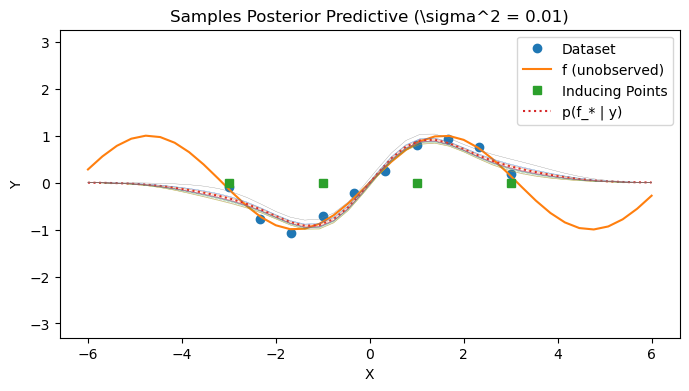

In [10]:
# Create posterior prediction
test_xs = jnp.linspace(-6, 6, 40).reshape(-1, 1)
post_mean = jax.vmap(lambda x_star: sor_post_pred_mean(k, zs, alpha, x_star))(test_xs)
post_cov = jax.vmap(lambda x_star: sor_post_pred_cov(k, Sigma, zs, K_uu, K_uf, A, x_star), out_axes=0)(test_xs)
post_ys = [random.normal(key, shape=(12,)) * jnp.sqrt(post_cov[i][0][0]) + post_mean[i] for i in range(len(test_xs))]

# Plot
with PlotContext(title="Samples Posterior Predictive (\sigma^2 = 0.01)", xlabel="X", ylabel="Y") as ax:
    # Plot dataset and inducing points
    plt.plot(xs, ys, marker="o", linestyle="None", label="Dataset")
    plt.plot(test_xs, [f(x) for x in test_xs], label="f (unobserved)")
    plt.plot(zs, jnp.zeros_like(zs), marker="s", linestyle="None", label="Inducing Points")

    # Plot posterior
    plt.plot(test_xs, post_mean, linestyle="dotted", label="p(f_* | y)")
    plt.plot(test_xs, post_ys, linewidth=0.2)

## Fully Independent Training Conditional (FITC) Approximation

The degeneracy of the covariance for SoR might motivate us to find a different sparse approximation. The **Fully Independent Training Conditional** (FITC) Approximation is one such alternative to SoR.

Define

$$
\Lambda = diag(K_{xx} - Q_{xx} + \Sigma)
$$

and

$$
B = (K_{zz} + K_{zx}\Lambda^{-1}K_{zx})^{-1} \,.
$$

Then the posterior is

$$
q_{FITC}(f_* | y) = \mathcal{N}(K_{*z}BK_{zx}\Lambda^{-1}y, K_{**} - Q_{**} + K_{*z}BK_{z*}) \,.
$$

See Appendix: FITC Approximation for more details.

In [11]:
def fit_fitc(k: Callable, Sigma, xs: Array, ys: Array, zs: Array):
    # Precompute kernels
    K_zz = mk_cov(k, zs, zs)
    K_zx = mk_cov(k, zs, xs)
    K_xz = K_zx.transpose()
    Q_xx = K_xz @ cholesky_inv(K_zz) @ K_zx
    
    # Lambda
    Lambda = jnp.diag(jnp.array([k(x, x) for x in xs]) - jnp.diag(Q_xx) + jnp.diag(Sigma))
    Lambda_inv = cholesky_inv(Lambda)
    # B
    B = cholesky_inv(K_zz + K_zx @ Lambda_inv @ K_xz)
    alpha = B @ K_zx @ Lambda_inv @ ys
    return alpha, K_zz, B

def fitc_post_pred_mean(k: Callable, zs: Array, alpha: Array, x_star: Array) -> Array:
    """FITC posterior predictive mean.
    """
    K_star_z = mk_cov(k, x_star, zs).reshape(-1)
    return K_star_z @ alpha

def fitc_post_pred_cov(k: Callable, Sigma: Array, zs: Array, K_zz: Array, B: Array, x_star: Array) -> Array:
    """FITC posterior predictive covariance.
    """
    K_star_star = mk_cov(k, x_star, x_star)
    K_star_z = mk_cov(k, x_star, zs)
    Q_star_star = K_star_z @ cholesky_inv(K_zz) @ K_star_z.transpose()
    return K_star_star - Q_star_star + K_star_z @ B @ K_star_z.transpose()

### Visualizing  the posterior predictive

We visualize the covariance of the posterior predictive by sampling a few times from the posterior predictive. Observe that the unertainty behavior of FITC approach is better now.

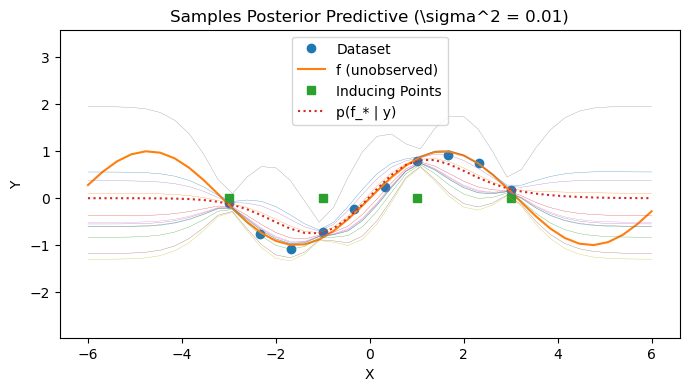

In [12]:
alpha, K_zz, B = fit_fitc(k, Sigma, xs, ys, zs)
post_mean = jax.vmap(lambda x_star: fitc_post_pred_mean(k, zs, alpha, x_star))(test_xs)
post_cov = jax.vmap(lambda x_star: fitc_post_pred_cov(k, Sigma, zs, K_zz, B, x_star), out_axes=0)(test_xs)
post_ys = [random.normal(key, shape=(12,)) * jnp.sqrt(post_cov[i][0][0]) + post_mean[i] for i in range(len(test_xs))]

with PlotContext(title="Samples Posterior Predictive (\sigma^2 = 0.01)", xlabel="X", ylabel="Y") as ax:
    # Plot dataset and inducing points
    plt.plot(xs, ys, marker="o", linestyle="None", label="Dataset")
    plt.plot(test_xs, [f(x) for x in test_xs], label="f (unobserved)")
    plt.plot(zs, jnp.zeros_like(zs), marker="s", linestyle="None", label="Inducing Points")

    # Plot posterior
    plt.plot(test_xs, post_mean, linestyle="dotted", label="p(f_* | y)")
    plt.plot(test_xs, post_ys, linewidth=0.2)

## Summary

1. We introduced the concept of using inducing points to summarize the entire dataset and make GP inference more tractable.
2. We illustrated the SoR approach which is based on inducing points.
3. We illustrated the FITC approach, another Sparse GP based on inducing points.

## References

1. Joaquin Quinonero-Candela and Carl Edward Rasmussen. [A Unifying View of Sparse Approximate Gaussian Process Regression](https://www.jmlr.org/papers/volume6/quinonero-candela05a/quinonero-candela05a.pdf)
2. Edward Snelson and Zoubin Ghahramani. [Sparse Gaussian Processes using Pseudo-inputs](https://papers.nips.cc/paper_files/paper/2005/file/4491777b1aa8b5b32c2e8666dbe1a495-Paper.pdf).
3. J. Emmanuel Johnson. [Sparse GP Notes](https://jejjohnson.github.io/research_journal/appendix/gps/2_sparse_gps/).

## Appendix

### Appendix: Multivariate Normal Facts

#### Matrix Inversion lemma (Woodbury, Sherman, Morrison formula)

The matrix inversion lemma is given below

$$
(Z + UWV^T)^{-1} = Z^{-1} - Z^{-1}U(W^{-1} + Z^TZ^{-1}U)^{-1}V^TZ^{-1} \,.
$$

### Appendix: SoR Simplification

We need to check
$$
K_{*u}(K_{uu} + K_{uf}\Sigma^{-1}K_{fu})^{-1}K_{uf} = Q_{*f}(Q_{ff} + \Sigma)^{-1}y \,.
$$

1. Observe that
\begin{align*}
\phantom{\iff} & Q_{ff} + \Sigma = Q_{ff} + \Sigma \tag{identity} \\
\iff & I = (Q_{ff} + \Sigma)^{-1}Q_{ff} + (Q_{ff} + \Sigma)^{-1}\Sigma \tag{mult by $(Q_{ff} + \Sigma)^{-1}$}\\
\iff & I - (Q_{ff} + \Sigma)^{-1}Q_{ff} = (Q_{ff} + \Sigma)^{-1}\Sigma \tag{rearrange} \\
\iff & Q_{*f} - Q_{*f}(Q_{ff} + \Sigma)^{-1}Q_{ff} = Q_{*f}(Q_{ff} + \Sigma)^{-1}\Sigma \tag{mult both sides by $Q_{*f}$} \\
\iff & K_{*u}K_{uu}^{-1}K_{uf} - K_{*u}K_{uu}^{-1}K_{uf}(K_{fu}K_{uu}^{-1}K_{uf} + \Sigma)^{-1}K_{fu}K_{uu}^{-1}K_{uf} = Q_{*f}(Q_{ff} + \Sigma)^{-1}\Sigma \tag{defn $Q_{ab}$} \\
\iff & K_{*u}(K_{uu}^{-1} - K_{uu}^{-1}K_{uf}(K_{fu}K_{uu}^{-1}K_{uf} + \Sigma)^{-1}K_{fu}K_{uu}^{-1})K_{uf} = Q_{*f}(Q_{ff} + \Sigma)^{-1}\Sigma \tag{factor} \\
\iff & K_{*u}(K_{uu} + K_{uf}\Sigma^{-1}K_{fu})^{-1} K_{uf} = Q_{*f}(Q_{ff} + \Sigma)^{-1}\Sigma \tag{matrix inversion lemma} \\
\iff & K_{*u}(K_{uu} + K_{uf}\Sigma^{-1}K_{fu})^{-1} K_{uf}\Sigma^{-1} = Q_{*f}(Q_{ff} + \Sigma)^{-1} \tag{mult $\Sigma$} \,.
\end{align*}

2. We can perform a similar check for the covariance.

### Appendix: Unifying View of Sparse GP 

Quinonero-Candela and Rasmussen [1] present a unifying construction for sparse GPs. The mean idea is to use an auxiliary random variable $u$ to mediate the interaction between $f$ and $f_*$.  In particular, we can rewrite the original joint distribution as
\begin{align*}
p(f, f_*) & = \int p(f_*, f, u) du \tag{marginalization} \\
& = \int p(f_*, f | u) p(u) du \tag{factor}
\end{align*}
where the distribution on the auxiliary variable $u$ is

$$
p(u) = \mathcal{N}(0, K_{uu}) \,.
$$

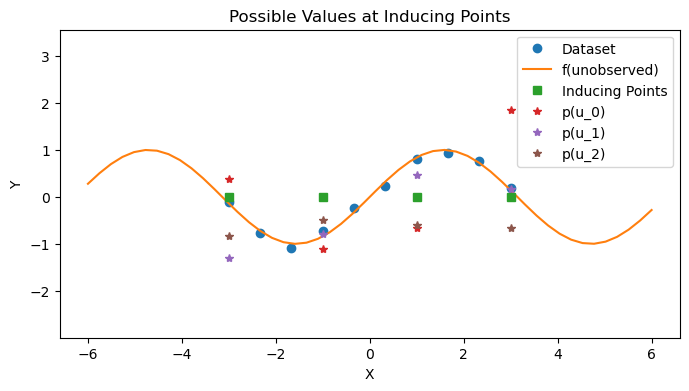

In [13]:
# Sample u
us = random.multivariate_normal(key, mean=jnp.zeros(M), cov=K_zz, shape=(3,)).transpose()

# Plot
with PlotContext(title="Possible Values at Inducing Points", xlabel="X", ylabel="Y") as ax:
    # Plot dataset and inducing points
    plt.plot(xs, ys, marker="o", linestyle="None", label="Dataset")
    plt.plot(jnp.linspace(-6, 6), f(jnp.linspace(-6, 6)), label="f(unobserved)")
    plt.plot(zs, jnp.zeros_like(zs), marker="s", linestyle="None", label="Inducing Points")

    # Plot samples
    for i in range(3):
        plt.plot(zs, us[:, i], marker="*", linestyle="None", label=f"p(u_{i})")

#### Unifying 1: Sparse GP Approximation

Recall that

$$
p(f_*, f) = \begin{pmatrix}
K_{**} & K_{*f} \\
K_{f*} & K_{ff}
\end{pmatrix}
$$

for a vanilla GP. We will introduce the approximation
\begin{align*}
p(f_*, f) & \approx q(f_*, f) \tag{fundamental approximation} \\
& = \int q(f_* | u) q(f | u) p(u) du \tag{inducing point approximation}
\end{align*}
so that $f_*$ and $f$ are conditionally independent given $u \sim \mathcal{N}(0, K_{uu})$. Different choice of $q(f_*, f)$ will then correspond to different approximations.

#### Unifying 2: SoR Approximation

1. The **subset of regressors** (SoR) method makes the following approximation to $p(f, f_*)$ as

$$
q_{SoR}\begin{pmatrix}
f \\
f_*
\end{pmatrix} = \mathcal{N} \left( \begin{pmatrix}
0 \\
0
\end{pmatrix}, \begin{pmatrix}
Q_{ff} & Q_{f*} \\
Q_{*f} & Q_{**}
\end{pmatrix} \right)
$$

where

$$
Q_{ab} = K_{au}K_{uu}^{-1}K_{ub} \,.
$$

Thus it is a GP regression with kernel $Q_{ab}$.

2. Observe that the joint distribution

$$
q_{SoR}\begin{pmatrix}
u \\
f \\
\end{pmatrix} = \mathcal{N} \left(
\begin{pmatrix}
0 \\
0 \end{pmatrix}, 
\begin{pmatrix}
K_{uu} & K_{uf} \\
K_{fu} & Q_{ff} \\
\end{pmatrix}
\right) 
$$

has conditional distribution
\begin{align*}
q_{SoR}(f|u) & = \mathcal{N}(K_{fu}K_{uu}^{-1}u, K_{fu}K_{uu}^{-1}k_{uf} - K_{fu}K_{uu}^{-1}K_{uf}) \\
& = \mathcal{N}(K_{fu}K_{uu}^{-1}u, 0) \,.
\end{align*}

and marginal distribution 

$$
q_{SoR}(u) = \mathcal{N}(0, K_{uu})
$$

as expected.

#### Unifying 2: FITC Approximation

1. The FITC method makes the following approximation to $p(f, f_*)$ as

$$
q_{FITC}\begin{pmatrix}
f \\
f_*
\end{pmatrix} = \mathcal{N} \left( \begin{pmatrix}
0 \\
0
\end{pmatrix}, \begin{pmatrix}
Q_{ff} - diag(Q_{ff} - K_{ff}) & Q_{f*} \\
Q_{*f} & K_{**}
\end{pmatrix} \right)
$$

where

$$
Q_{ab} = K_{au}K_{uu}^{-1}K_{ub} \,.
$$

2. Observe that the joint distribution

$$
q_{FITC}\begin{pmatrix}
u \\
f \\
\end{pmatrix} = \mathcal{N} \left(
\begin{pmatrix}
0 \\
0 \end{pmatrix}, 
\begin{pmatrix}
K_{uu} & Q_{uf} \\
Q_{fu} & Q_{ff} - diag(Q_{ff} - K_{ff}) \\
\end{pmatrix}
\right) 
$$

has conditional distribution

$$
q_{FITC}(f | u) = \mathcal{N}(Q_{fu}K_{uu}^{-1}u, Q_{ff} - diag(Q_{ff} - K_{ff})) \,.
$$

#### Unifying 3: Comparing conditionals of original, SoR, and FITC

- $p(f | u) = \mathcal{N}(K_{fu}K_{uu}^{-1}u, K_{ff} - K_{fu}K_{uu}^{-1}K_{uf})$
- $q_{SoR}(f|u) = \mathcal{N}(K_{fu}K_{uu}^{-1}u, 0)$
- $q_{FITC}(f | u) = \mathcal{N}(Q_{fu}K_{uu}^{-1}u, Q_{ff} - diag(Q_{ff} - K_{ff}))$